#**CNN Model Training using Transfer Learning**
 

* Transfer learning is a method where knowledge gathered from one problem are used to solve similar or new problem.
* Transfer learning is usually done for tasks where your dataset has too little data to train a full-scale model from scratch.

***A. How to perform transfer learning?***
1. Take layers from a previously trained model.
2. Freeze all/some initial layers of the model.
3. Add some new layers in the model.
4. Train the new layers on new dataset.

***B. How to perform fine-tuning?***
1. Unfreezing the entire model 
2. Re-training it on the new data

# Drive Mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/CVDL

[Errno 2] No such file or directory: '/content/drive/My Drive/Colab Notebooks/CVDL'
/content


In [ ]:
!unzip rps-cv-images.zip

unzip:  cannot find or open rps-cv-images.zip, rps-cv-images.zip.zip or rps-cv-images.zip.ZIP.


**Dividing the dataset into training, validation and test sets**

To split the dataset we will use split-folders a python package under MIT license.

Link: https://pypi.org/project/split-folders/

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders   # or import split_folders

In [ ]:
input_folder='/content/drive/My Drive/Canvas/Day 1/rps-cv-images/rps-cv-images'
# Split with a ratio.
# To only split into training(80%), testing(10%), and validation(10%) set, using 'ratio' i.e (.8, .1, .1) 
splitfolders.ratio(input_folder, output="output", seed=1337, ratio=(.8, .1, .1))

Copying files: 2182 files [08:42,  4.17 files/s]


**Import necessary packages**

In [ ]:
import os
import numpy as np
import keras
import glob
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import matplotlib.pyplot as plt

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model

**Data Preprocessing**

Keras provides the ImageDataGenerator class for data preprocessing and data augmentation.

1. rotation_range: Degree range for random rotations.
2. horizontal_flip: Randomly flip inputs horizontally
3. zoom_range: Range for random zoom.
4. shear_range: Shear Intensity (Shear angle in counter-clockwise direction in degrees)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255
                                   #horizontal_flip=True, vertical_flip=True, 
                                   #rotation_range=15,shear_range=15,
                                   #zoom_range=0.15
                                   )

test_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        "output/train",
        target_size=(300, 200),
        batch_size=64,
        class_mode='categorical'
        )
 
validation_generator = validation_datagen.flow_from_directory(
        'output/val',
        target_size=(300, 200),
        batch_size=64,
        class_mode='categorical',
        shuffle=False)

test_generator = test_datagen.flow_from_directory(
        'output/test',
        target_size=(300, 200),
        batch_size=64,
        class_mode='categorical',
        shuffle=False)

Found 1745 images belonging to 3 classes.
Found 217 images belonging to 3 classes.
Found 220 images belonging to 3 classes.


# Transfer Learning

**A. Implementation of tranfer learning using keras:**

1. Instantiate a base model and load pre-trained weights into it.
2. Freeze all layers in the base model by setting trainable = False.
3. Create a new model on top of the output of one (or several) layers from the base model.
4. Train new model on new dataset.

**A.1 Loading the ResNet50 model with ImageNet pre-trained weights**

In [ ]:
resnet = ResNet50(include_top=False, 
                   weights='imagenet', 
                   input_shape=(300, 200,3))
#resnet.summary()

**A.2 Freeze all the layers of ResNet50**

In [ ]:
for layer in resnet.layers[:-4]:
  layer.trainable = False

In [ ]:
#resnet.trainable = False
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 206, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 100, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
from keras import models
from keras import layers
from keras import optimizers

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential

**A.3 Adding new layers to ResNet model**

In [ ]:
# Create the model
model = models.Sequential()
# Add the resnet convolutional base model
model.add(resnet)

# Add new layers
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(1024))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dense(512))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Dense(3, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 10, 7, 2048)       23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2

**A.4 Model Compilation**

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])

**A.5 Model Training**

In [ ]:
from keras.callbacks import ModelCheckpoint
filepath='best_weights.hdf5'
checkpointer=ModelCheckpoint(filepath,monitor='val_acc',mode='max',save_best_only=True,verbose=1)
epochs = 20
history=model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=epochs,
        callbacks=[checkpointer],
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size,
        verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 0.4605 - acc: 0.8483
Epoch 00001: val_acc improved from -inf to 0.25521, saving model to best_weights.hdf5
27/27 [==============================] - 10s 355ms/step - loss: 0.4605 - acc: 0.8483 - val_loss: 1.1203 - val_acc: 0.2552
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 0.1493 - acc: 0.9673
Epoch 00002: val_acc did not improve from 0.25521
27/27 [==============================] - 8s 289ms/step - loss: 0.1493 - acc: 0.9673 - val_loss: 1.1311 - val_acc: 0.2552
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 0.0898 - acc: 0.9786
Epoch 00003: val_acc improved from 0.25521 to 0.28125, saving model to best_weights.hdf5
27/27 [==============================] - 8s 296ms/step - loss: 0.0898 - acc: 0.9786 - val_loss: 1.0990 - val_acc: 0.2812
Epoch 4/20
27/27 [==============================] - ETA: 0s - loss: 

**A.6 Testing the performance of the model**

In [ ]:
model.load_weights(filepath)
test_output= model.evaluate_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)

print(test_output)
print(model.metrics_names)

4/3 [==================================] - 1s 154ms/step - loss: 0.9851 - acc: 0.6136
[0.9851409792900085, 0.6136363744735718]
['loss', 'acc']


**A.7 Plotting the training accuracy and loss graph**

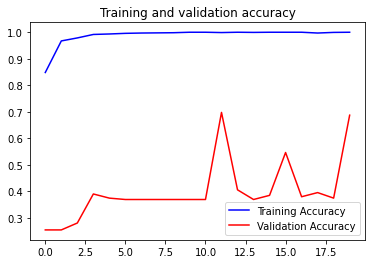

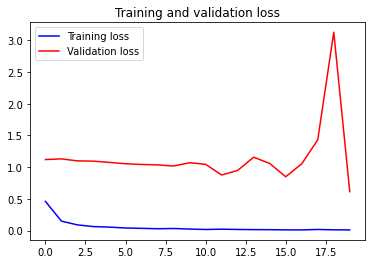

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# FINE TUNING

**B.1 Loading the ResNet50 model with ImageNet pre-trained weights**

In [ ]:
new_base_model =keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224,3)
)
new_base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

**B.2 Adding new layers to ResNet model**


In [ ]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
new_model = models.Sequential()
# Add the resnet convolutional base model
new_model.add(new_base_model)

# Add new layers
new_model.add(layers.GlobalAveragePooling2D())
new_model.add(layers.Dense(1024))
new_model.add(layers.BatchNormalization())
new_model.add(layers.Activation('relu'))
new_model.add(layers.Dense(512))
new_model.add(layers.BatchNormalization())
new_model.add(layers.Activation('relu'))

new_model.add(layers.Dense(3, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_2 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)              

**B.3 Model Compilation**

In [ ]:
new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

**B.4 Model Training**

In [ ]:
from keras.callbacks import ModelCheckpoint
filepath='finetuning_best_weights.hdf5'
checkpointer=ModelCheckpoint(filepath,monitor='val_acc',mode='max',save_best_only=True,verbose=1)
epochs = 10
new_history=new_model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=epochs,
        callbacks=[checkpointer],
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size,
        verbose=1)

Epoch 1/10
27/27 [==============================] - ETA: 0s - loss: 0.1558 - acc: 0.9459
Epoch 00001: val_acc improved from -inf to 0.25521, saving model to finetuning_best_weights.hdf5
27/27 [==============================] - 24s 892ms/step - loss: 0.1558 - acc: 0.9459 - val_loss: 8214.5713 - val_acc: 0.2552
Epoch 2/10
27/27 [==============================] - ETA: 0s - loss: 0.0239 - acc: 0.9923
Epoch 00002: val_acc improved from 0.25521 to 0.37500, saving model to finetuning_best_weights.hdf5
27/27 [==============================] - 23s 837ms/step - loss: 0.0239 - acc: 0.9923 - val_loss: 6.3088 - val_acc: 0.3750
Epoch 3/10
27/27 [==============================] - ETA: 0s - loss: 0.0543 - acc: 0.9875
Epoch 00003: val_acc did not improve from 0.37500
27/27 [==============================] - 22s 802ms/step - loss: 0.0543 - acc: 0.9875 - val_loss: 2.3784 - val_acc: 0.3750
Epoch 4/10
27/27 [==============================] - ETA: 0s - loss: 0.0371 - acc: 0.9863
Epoch 00004: val_acc did not

**B.5 Testing the performance of the model**

In [ ]:
new_model.load_weights(filepath)
test_output= new_model.evaluate_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
print(test_output)
print(new_model.metrics_names)

4/3 [==================================] - 1s 159ms/step - loss: 5.9794 - acc: 0.3318
[5.979435920715332, 0.33181819319725037]
['loss', 'acc']


**B.6 Plotting the training accuracy and loss graph**

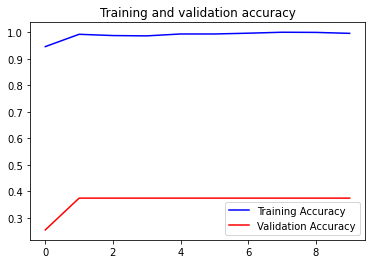

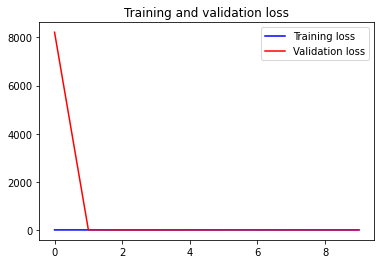

In [ ]:
import matplotlib.pyplot as plt
acc = new_history.history['acc']
val_acc = new_history.history['val_acc']
loss = new_history.history['loss']
val_loss = new_history.history['val_loss']
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

References:

1. https://keras.io/guides/transfer_learning/

2. https://pypi.org/project/split-folders/

3. https://keras.io/api/applications/

4. https://keras.io/api/preprocessing/image/